In [3]:
STOCK_SIZE = 100

In [4]:
def read_instance(path):
    with open(path, 'r') as f:
        orders = [int(x) for x in f.readline().split()]
        return orders

nk - The number of the ordered small items by the length of l k .

N - The number of all small items.

li - The length of the i th ordered item.

M - The number of all large objects. - moze da ne bude dato u zadatku vec da se izracuna u initialize f-ji

Lj - The length of the j th large object.

wj - The trim loss appeared on j th large object.

Xij - A binary variable which is equal to one if the i th Item is cut from the j th large object and
zero otherwise.

wj = Lj − for i in range(N) for j in range(M)(li * xij) - calc trim loss 

0 <= wj <= Lj - logicno

0 < j < M - materijal koji imamo

0 < i < N - broj porucenih 

# Cplex

In [8]:
from docplex.mp.model import Model

In [9]:
orders = read_instance('test_instances/test_instance_11.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

775902 317


In [10]:
model = Model(name='CSP')

In [11]:
num_stocks = len(orders)
num_orders = len(orders)

order_list = model.integer_var_list(num_orders, lb=orders, ub=orders, name='orders')

In [12]:
order_placement = model.binary_var_matrix(num_stocks, num_orders, name='order_placement')
stock_used = model.binary_var_list(num_stocks, name='stock_used')

In [13]:
for i in range(num_stocks):
    model.add_constraint(sum(order_placement[i,j] * order_list[j] for j in range(num_orders)) <= STOCK_SIZE * stock_used[i])
    
for j in range(num_orders):
    model.add_constraint(sum(order_placement[i,j] for i in range(num_stocks)) == 1)
    
model.minimize(sum(stock_used))

In [14]:
solution = model.solve()

In [16]:
print(solution.get_objective_value())

299.0


# Simulated annealing

In [5]:
import math
from matplotlib import pyplot as plt
import random
from copy import deepcopy

In [6]:
def initialize(orders: list[int], shuffle: bool = False) -> list[int]:
    solution = deepcopy(orders)
    if shuffle:
        random.shuffle(solution)
    return solution

In [7]:
def calc_solution_value(orders: list[int]) -> tuple[int, int]:
    
    leftovers = []
    num_stocks = 0
    current_stock_size = STOCK_SIZE
    
    for order in orders:
        if order <= current_stock_size:
            current_stock_size -= order
        else:
            leftover = current_stock_size
            leftovers.append(leftover)
            num_stocks += 1
            current_stock_size = STOCK_SIZE - order
    
    if current_stock_size != STOCK_SIZE:
        leftovers.append(current_stock_size)
        
    leftovers.sort(reverse = True)
        
    result = 0    
    for i, leftover in enumerate(leftovers):
        if leftover == 0:
            break
        result += (i+1) * leftover
        
    return result, num_stocks

In [8]:
def multiple_swaps(orders: list[int]):
    num_orders = len(orders)
    idxs = list(range(num_orders))
    random_length = random.randrange(1, num_orders)
    chosen = random.sample(idxs, k = random_length)
    for i in range(random_length):
        for j in range(chosen[i] + 1, num_orders):
            if orders[chosen[i]] != orders[j]:
                tmp = orders[chosen[i]]
                orders[chosen[i]] = orders[j]
                orders[j] = tmp
                break
                
def swap(orders: list[int]): 
    idx1 = random.randrange(len(orders))
    idx2 = random.randrange(len(orders))
    while orders[idx1] == orders[idx2]:
        idx2 = random.randrange(len(orders))
        
    tmp = orders[idx1]
    orders[idx1] = orders[idx2]
    orders[idx2] = tmp

In [9]:
def calc_temperature_1(current_temp: float, alpha: float) -> float:
    return current_temp / (1 + alpha * current_temp)

def calc_temperature_2(current_temp: float, alpha: float) -> float:
    return current_temp * alpha

def calc_alpha(initial_temp: float, min_temp: float) -> float:
    return (initial_temp - min_temp) / (num_iters * initial_temp * min_temp)

In [10]:
from typing import Callable

def simulated_annealing(orders: list[int],
                        initial_temp: float = 100,
                        min_temp: float = 10,
                        alpha: float = 0.9,
                        max_iters: int = 10000,
                        make_small_change: Callable[[list[int]], None] = swap,
                        calc_temperature: Callable[[float, float], float] = calc_temperature_1,
                        plot: bool = False,
                        max_accepted_solutions: int = 3
                        ) -> tuple[list[int], int, int]:
    
    num_orders = len(orders)
    solution = initialize(orders)
    temperature = initial_temp
    
    value, stocks_used = calc_solution_value(solution)
    best_solution = deepcopy(solution)
    best_value = value
    best_stocks_used = stocks_used

    PLT_VALUES = []
    PLT_STOCKS_USED = []
    ITERS = 0
    
    while temperature > min_temp and ITERS < max_iters:
        accepted_solutions = 0
        new_solution = deepcopy(solution)
        make_small_change(new_solution)
        new_value, new_stocks_used = calc_solution_value(new_solution)
        
        diff = new_value - value
        if diff <= 0:
            solution = deepcopy(new_solution)
            value = new_value
            stocks_used = new_stocks_used
            
            if new_value < best_value:
                best_value = new_value
                best_solution = deepcopy(new_solution)
                best_stocks_used = new_stocks_used
                
            accepted_solutions += 1    
            
        elif random.random() < (math.e)**((-diff) / temperature):
                value = new_value
                solution = deepcopy(new_solution)
                stocks_used = new_stocks_used
                accepted_solutions += 1
        
        if diff > 0 or accepted_solutions >= max_accepted_solutions:
            temperature = calc_temperature(temperature, alpha)
        
        PLT_VALUES.append(value)
        PLT_STOCKS_USED.append(stocks_used)
        ITERS += 1
            
    if plot:      
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
    
    return best_solution, best_value, best_stocks_used

In [30]:
orders = [20, 30, 50, 10, 5, 5, 80, 35, 25, 40, 8, 12, 33, 27, 20, 90, 10, 90, 2, 3, 4, 1]
random.shuffle(orders)

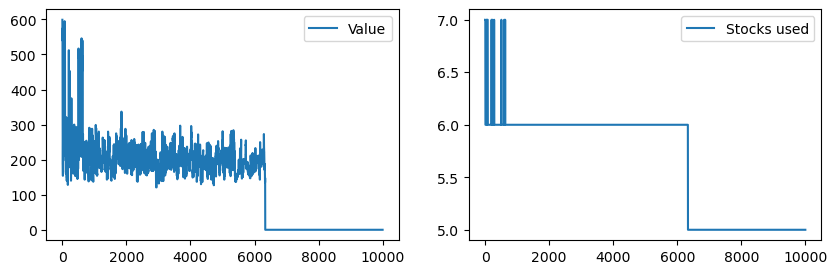

[50, 35, 2, 1, 12, 80, 20, 90, 10, 33, 40, 27, 3, 5, 4, 8, 30, 5, 20, 25, 90, 10] 0 5


In [31]:
initial_temp = 100
min_temp = 10
num_iters = 10000 # todo
a = calc_alpha(initial_temp, min_temp)
solution, value, stocks_used = simulated_annealing(orders, alpha=a, plot=True)
print(solution, value, stocks_used)

In [65]:
orders = read_instance('test_instances/test_instance_20.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

4478851 751


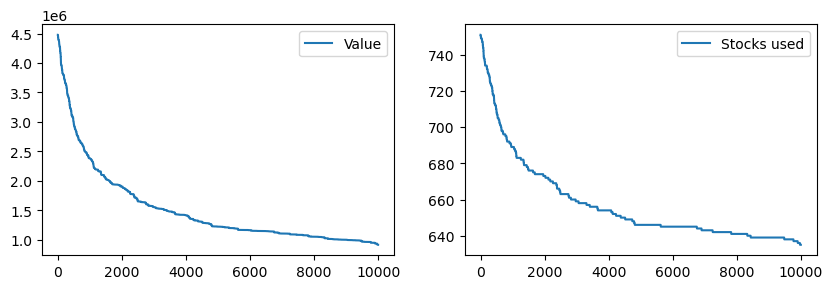

917027 635


In [62]:
#Staro

solution, value, stocks_used = simulated_annealing(orders, alpha=a, plot=True)
print(value, stocks_used)

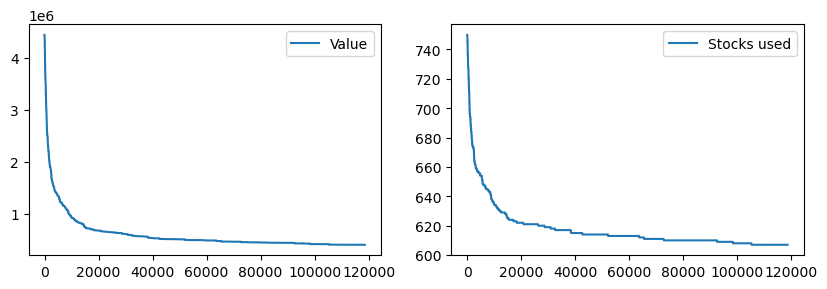

407144 607


In [68]:
solution, value, stocks_used = simulated_annealing(orders, alpha=a, plot=True, max_iters=1000000, min_temp=1)
print(value, stocks_used)

In [23]:
orders = read_instance('test_instances/test_instance_6.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

137384 118


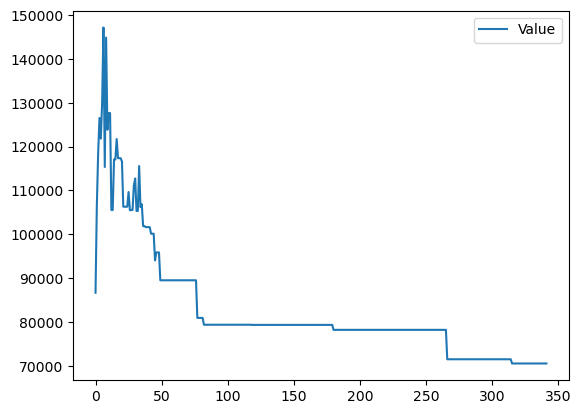

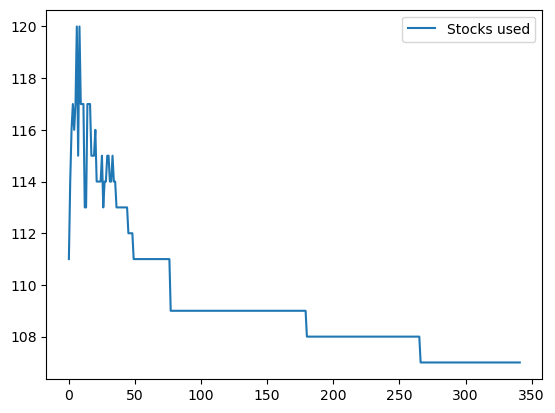

70518 107


In [24]:
solution, value, stocks_used = simulated_annealing(orders, T=40000, min_temperature=1e-3, a=0.95)
print(value, stocks_used)

### Grid search

In [43]:
import itertools

initial_temps = [50, 100, 150]
min_temps = [5, 10, 15]
max_iters = [5000, 10000, 20000]
temp_functions = [calc_temperature_1, calc_temperature_2]
max_accepted = [1, 2, 3, 4]

all_combinations = itertools.product(initial_temps, min_temps, max_iters, temp_functions, max_accepted)

In [49]:
orders = read_instance('test_instances/test_instance_20.csp')
initial_value, initial_stocks_used = calc_solution_value(orders)
print(initial_value, initial_stocks_used)

4478851 751


In [46]:
results = {}

num_combinations = len(initial_temps) * len(min_temps) * len(max_iters) * len(temp_functions) * len(max_accepted)
idx = 1

for combination in all_combinations:
    print(f'{idx}/{num_combinations}         ', end='\r')
    idx += 1
    initial_temp, min_temp, max_iters, calc_temp, max_accepted = combination
    alpha = calc_alpha(initial_temp, min_temp)
    
    solution, value, stocks_used = simulated_annealing(orders=orders,
                                                       initial_temp=initial_temp,
                                                       min_temp=min_temp,
                                                       alpha=alpha,
                                                       max_iters=max_iters,
                                                       calc_temperature=calc_temp,
                                                       max_accepted_solutions=max_accepted)
    results[combination] = (solution, value, stocks_used)

In [47]:
sorted_results = sorted(results.items(), key=lambda x: x[1][1])
for combination, (solution, value, stocks_used) in sorted_results[:10]:
    print(f"Combination: {combination}, Value: {value}, Stocks Used: {stocks_used}")

Combination: (150, 10, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), Value: 786169, Stocks Used: 627
Combination: (100, 15, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), Value: 794130, Stocks Used: 628
Combination: (100, 5, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), Value: 808134, Stocks Used: 628
Combination: (150, 15, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), Value: 820086, Stocks Used: 629
Combination: (50, 5, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 4), Value: 823690, Stocks Used: 630
Combination: (150, 15, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 4), Value: 826539, Stocks Used: 631
Combination: (150, 15, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 3), Value: 830536, Stocks Used: 630
Combination: (100, 10, 20000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), Value: 831471, Stocks Used: 630
Combination: (100, 10, 10000, <function calc_temperature_1 at 0x7f0b2f008940>, 2), 

In [52]:
initial_temps = [50, 100, 150, 300]
min_temps = [5, 10, 15]
max_iters = [20000, 50000, 100000]
max_accepted = [2, 3, 4, 5]

all_combinations = itertools.product(initial_temps, min_temps, max_iters, max_accepted)

In [53]:
results = {}

num_combinations = len(initial_temps) * len(min_temps) * len(max_iters) * len(max_accepted)
idx = 1

for combination in all_combinations:
    print(f'{idx}/{num_combinations}         ', end='\r')
    idx += 1
    initial_temp, min_temp, max_iters, max_accepted = combination
    alpha = calc_alpha(initial_temp, min_temp)
    
    solution, value, stocks_used = simulated_annealing(orders=orders,
                                                       initial_temp=initial_temp,
                                                       min_temp=min_temp,
                                                       alpha=alpha,
                                                       max_iters=max_iters,
                                                       calc_temperature=calc_temperature_1,
                                                       max_accepted_solutions=max_accepted)
    results[combination] = (solution, value, stocks_used)

In [59]:
sorted_results = sorted(results.items(), key=lambda x: x[1][1])
for combination, (solution, value, stocks_used) in sorted_results[:20]:
    print(f"Combination: {combination}, Value: {value}, Stocks Used: {stocks_used}")

Combination: (100, 15, 20000, 5), Value: 757766, Stocks Used: 627
Combination: (300, 10, 100000, 4), Value: 764008, Stocks Used: 626
Combination: (100, 5, 50000, 4), Value: 765926, Stocks Used: 626
Combination: (50, 10, 50000, 4), Value: 770923, Stocks Used: 625
Combination: (150, 15, 100000, 2), Value: 780601, Stocks Used: 627
Combination: (50, 15, 100000, 2), Value: 783453, Stocks Used: 627
Combination: (300, 5, 20000, 4), Value: 783823, Stocks Used: 626
Combination: (300, 5, 100000, 2), Value: 784914, Stocks Used: 627
Combination: (150, 15, 50000, 2), Value: 786226, Stocks Used: 628
Combination: (50, 5, 100000, 5), Value: 790864, Stocks Used: 627
Combination: (300, 5, 50000, 2), Value: 790872, Stocks Used: 627
Combination: (100, 15, 100000, 4), Value: 792112, Stocks Used: 628
Combination: (100, 5, 100000, 2), Value: 792373, Stocks Used: 629
Combination: (50, 15, 50000, 5), Value: 796108, Stocks Used: 628
Combination: (300, 15, 50000, 2), Value: 800251, Stocks Used: 628
Combination: 

In [90]:
initial_temps = [random.randrange(50, 150) for _ in range(2)]
min_temps = [random.randrange(1, 15) for _ in range(2)]
max_iters = [random.randrange(1000000, 10000000) for _ in range(2)]
max_accepted = [random.randrange(1, 6) for _ in range(2)]

all_combinations = itertools.product(initial_temps, min_temps, max_iters, max_accepted)

In [91]:
results = {}
num_combinations = len(initial_temps) * len(min_temps) * len(max_iters) * len(max_accepted)
idx = 1

for combination in all_combinations:
    print(f'{idx}/{num_combinations}  ', end='\r')
    idx += 1
    initial_temp, min_temp, max_iters, max_accepted = combination
    alpha = calc_alpha(initial_temp, min_temp)
    
    solution, value, stocks_used = simulated_annealing(orders=orders,
                                                       initial_temp=initial_temp,
                                                       min_temp=min_temp,
                                                       alpha=alpha,
                                                       max_iters=max_iters,
                                                       calc_temperature=calc_temperature_1,
                                                       max_accepted_solutions=max_accepted)
    results[combination] = (solution, value, stocks_used)

In [92]:
sorted_results = sorted(results.items(), key=lambda x: x[1][1])
for combination, (solution, value, stocks_used) in sorted_results[:20]:
    print(f"Combination: {combination}, Value: {value}, Stocks Used: {stocks_used}")

Combination: (81, 11, 9346801, 4), Value: 795702, Stocks Used: 628
Combination: (138, 11, 9346801, 4), Value: 824889, Stocks Used: 629
Combination: (138, 4, 5967418, 4), Value: 825911, Stocks Used: 628
Combination: (81, 4, 5967418, 4), Value: 829744, Stocks Used: 631
Combination: (81, 4, 9346801, 1), Value: 847331, Stocks Used: 630
Combination: (81, 11, 9346801, 1), Value: 848612, Stocks Used: 630
Combination: (138, 11, 5967418, 4), Value: 850587, Stocks Used: 631
Combination: (138, 4, 9346801, 4), Value: 851102, Stocks Used: 631
Combination: (81, 11, 5967418, 4), Value: 858320, Stocks Used: 630
Combination: (81, 4, 9346801, 4), Value: 866810, Stocks Used: 632
Combination: (138, 4, 9346801, 1), Value: 873428, Stocks Used: 632
Combination: (138, 4, 5967418, 1), Value: 885159, Stocks Used: 632
Combination: (81, 11, 5967418, 1), Value: 889407, Stocks Used: 632
Combination: (81, 4, 5967418, 1), Value: 901591, Stocks Used: 632
Combination: (138, 11, 9346801, 1), Value: 908421, Stocks Used: 

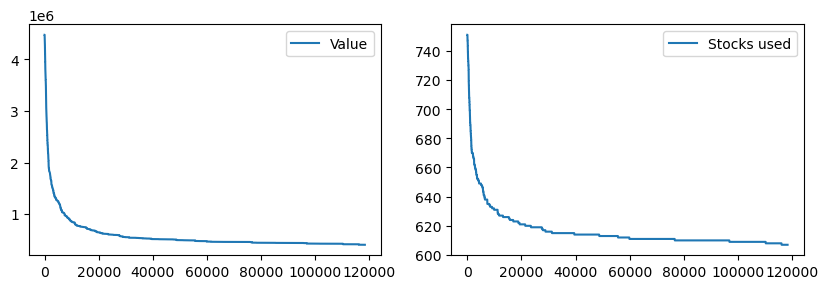

403793 607


In [93]:
solution, value, stocks_used = simulated_annealing(orders, alpha=a, plot=True, max_iters=1000000, min_temp=1)
print(value, stocks_used)

# Genetic algorithm

In [11]:
POPULATION_SIZE = 50
NUM_ITERS = 200
ELITISM_SIZE = 6
MUTATION_PROB = 0.02
CROSSOVER_PROB = 0.9
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.5     # [1.0, 2.0]
MC_OPTION = 'FIXED'

class Individual:
    def __init__(self, orders):
        code = deepcopy(orders)
        random.shuffle(code)
        self.code = code
        self.fitness, self.num_stocks = calc_solution_value(self.code)

In [12]:
def ga(orders:    list[int],
       selection: Callable[[list[Individual], Individual], Individual],
       crossover: Callable[[Individual, Individual, Individual, Individual], None],
       mutation:  Callable[[Individual], None],
       plot: bool,
       POPULATION_SIZE: int,
       MC_OPTION: str,
       CROSSOVER_PROB: float,
       MUTATION_PROB: float,
       NUM_ITERS: int,
       ELITISM_SIZE: int
      ):
    
    population = [Individual(orders) for _ in range(POPULATION_SIZE)]
    new_population = deepcopy(population)
    
    PLT_VALUES = []
    PLT_STOCKS_USED = []
    
    for it in range(NUM_ITERS):
        population.sort(key=lambda x: x.fitness)
        new_population[:ELITISM_SIZE] = deepcopy(population[:ELITISM_SIZE])
        
        PLT_VALUES.append(population[0].fitness)
        PLT_STOCKS_USED.append(population[0].num_stocks)
        
        if MC_OPTION == 'DHM/ILC':
            MUTATION_PROB = 1 - (it / (NUM_ITERS - 1))
            MUTATION_PROB = mutation_lb + (mutation_ub - mutation_lb) * MUTATION_PROB

            CROSSOVER_PROB = it / (NUM_ITERS - 1)
            CROSSOVER_PROB = crossover_lb + (crossover_ub - crossover_lb) * CROSSOVER_PROB
            
        elif MC_OPTION == 'ILM/DHC':
            MUTATION_PROB = it / (NUM_ITERS - 1)
            MUTATION_PROB = mutation_lb + (mutation_ub - mutation_lb) * MUTATION_PROB
            
            CROSSOVER_PROB = 1 - (it / (NUM_ITERS - 1))
            CROSSOVER_PROB = crossover_lb + (crossover_ub - crossover_lb) * CROSSOVER_PROB
            
        for i in range(ELITISM_SIZE, POPULATION_SIZE, 2):            
            parent1 = selection(population, None)
            parent2 = selection(population, parent1)
                
            if random.random() < CROSSOVER_PROB:
                crossover(parent1, parent2, new_population[i], new_population[i+1])
            else:
                new_population[i] = deepcopy(parent1)
                new_population[i+1] = deepcopy(parent2)
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i])
            
            if random.random() < MUTATION_PROB:
                mutation(new_population[i+1]) 
                                       
            new_population[i].fitness, new_population[i].num_stocks = calc_solution_value(new_population[i].code)
            new_population[i+1].fitness, new_population[i+1].num_stocks = calc_solution_value(new_population[i+1].code)
        
        population = deepcopy(new_population)
    
    if plot:
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 2, 1)
        plt.plot(range(NUM_ITERS), PLT_VALUES, label='Value')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(NUM_ITERS), PLT_STOCKS_USED, label='Stocks used')
        plt.legend()
        plt.show()
    
    best_individual = min(population, key=lambda x: x.fitness)
    return best_individual.code, best_individual.fitness, best_individual.num_stocks

### Selection

In [13]:
import numpy as np

In [14]:
def tournament_selection(population, forbidden):
    allowed = list(set(population).difference({forbidden}))
    chosen = random.sample(allowed, TOURNAMENT_SIZE)
    return min(chosen, key=lambda x: x.fitness)

In [15]:
def roulette_selection(population, forbidden):    
    allowed = list(set(population).difference({forbidden}))
    allowed.sort(key=lambda x: x.fitness)
    fitness_sum = sum([a.fitness for a in allowed])
    
    probs = [a.fitness / fitness_sum for a in allowed]
    probs.reverse()
    
    return np.random.choice(allowed, p=probs)

In [16]:
def rank_selection(population, forbidden):    
    allowed = list(set(population).difference({forbidden}))
    allowed.sort(key=lambda x: x.fitness)
    n = len(allowed)
    probs = [0 for i in range(n)]
    
    for i, individual in enumerate(allowed):
        probs[i] = (1 / n) * ( (SELECTION_PRESSURE - (2 * SELECTION_PRESSURE - 2) * ( i / (n - 1))) )
                        
    return np.random.choice(allowed, p=probs)    

### Crossover

In [17]:
def partially_mapped_crossover(parent1, parent2, child1, child2):
    n = len(parent1.code)
    pos1 = random.randrange(1, int(round(n/2)))
    pos2 = pos1 + random.randrange(int(round(n/3)), int(round(n/2)))
    
    temp_array1 = [(0,0) for _ in range(len(parent1.code))]
    temp_array2 = [(0,0) for _ in range(len(parent1.code))]
    
    ind_array1 = []
    ind_array2 = []
    
    count_dict1 = {}
    count_dict2 = {}

    for num in parent1.code:
        count_dict1[num] = count_dict1.get(num, 0) + 1
        ind_array1.append(count_dict1[num])
              
    for num in parent2.code:
        count_dict2[num] = count_dict2.get(num, 0) + 1
        ind_array2.append(count_dict2[num])
      
    temp_array1[pos1:pos2] = [(parent2.code[i],ind_array2[i]) for i in range(pos1, pos2)]
    temp_array2[pos1:pos2] = [(parent1.code[i],ind_array1[i]) for i in range(pos1, pos2)]

    
    #todo
    ind = 0
    for i in range(len(parent1.code)):
        if i < pos1 or i >= pos2:
            while True:
                if (parent1.code[ind], ind_array1[ind]) not in temp_array1:
                    temp_array1[i] = (parent1.code[ind], ind_array1[ind])
                    ind += 1
                    break
                else:
                    ind += 1
      
    ind = 0
    for i in range(len(parent1.code)):
        if i < pos1 or i >= pos2:
            while True:
                if (parent2.code[ind], ind_array2[ind]) not in temp_array2:
                    temp_array2[i] = (parent2.code[ind], ind_array2[ind])
                    ind += 1
                    break
                else:
                    ind += 1
                    
    for i in range(len(parent1.code)):
        child1.code[i] = temp_array1[i][0]
        child2.code[i] = temp_array2[i][0]

In [18]:
def generalized_order_crossover(parent1, parent2, child1, child2):
    n = len(parent1.code)
    pos1 = random.randrange(1, int(round(n/2)))
    pos2 = pos1 + random.randrange(int(round(n/3)), int(round(n/2)))
    
    ind_array1 = []
    ind_array2 = []
    
    count_dict1 = {}
    count_dict2 = {}

    for num in parent1.code:
        count_dict1[num] = count_dict1.get(num, 0) + 1
        ind_array1.append(count_dict1[num])
              
    for num in parent2.code:
        count_dict2[num] = count_dict2.get(num, 0) + 1
        ind_array2.append(count_dict2[num])
      
    chosen1 = [(parent1.code[i], ind_array1[i]) for i in range(pos1, pos2)]
    chosen2 = [(parent2.code[i], ind_array2[i]) for i in range(pos1, pos2)]

    result1 = []
    result2 = []

    for i,num in enumerate(parent2.code):
        if (num, ind_array2[i]) == chosen1[0]:
            result1.extend([x[0] for x in chosen1])
            continue
        if (num, ind_array2[i]) in chosen1:
            continue
        result1.append(num)
        
    for i,num in enumerate(parent1.code):
        if (num, ind_array1[i]) == chosen2[0]:
            result2.extend([x[0] for x in chosen2])
            continue
        if (num, ind_array1[i]) in chosen2:
            continue
        result2.append(num)
       
    child1.code = result1
    child2.code = result2

In [19]:
from copy import deepcopy

In [20]:
def precedence_preservative_crossover(parent1, parent2, child1, child2):
    chosen_parent1 = random.choices([1, 2], k=len(parent1.code))
    chosen_parent2 = [2 if x == 1 else 1 for x in chosen_parent1]
    
    p1 = deepcopy(parent1.code)
    p2 = deepcopy(parent2.code)
    
    p12 = deepcopy(p1)
    p22 = deepcopy(p2)
    
    for i, num in enumerate(chosen_parent1):
        if num == 1:
            child1.code[i] = p1[0]
            p2.remove(p1[0])
            p1.pop(0)
            
        elif num == 2:
            child1.code[i] = p2[0]
            p1.remove(p2[0])
            p2.pop(0)
            
    for i, num in enumerate(chosen_parent2):
        if num == 1:
            child2.code[i] = p12[0]
            p22.remove(p12[0])
            p12.pop(0)
            
        elif num == 2:
            child2.code[i] = p22[0]
            p12.remove(p22[0])
            p22.pop(0)
    

### Mutation

In [21]:
def mutation_swap(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
    
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))

    tmp = instance.code[pos1]
    instance.code[pos1] = instance.code[pos2]
    instance.code[pos2] = tmp

In [22]:
def mutation_insert(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
    
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))
        
    element = instance.code.pop(pos1)
    instance.code.insert(pos2, element)

In [23]:
def mutation_inverse(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
        
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))
                
    if pos1 > pos2:
        pos1,pos2 = pos2,pos1
        
    instance.code[pos1:pos2 + 1] = instance.code[pos1:pos2 + 1][::-1]

In [24]:
def mutation_shuffle(instance):
    pos1 = random.randrange(len(instance.code))
    pos2 = random.randrange(len(instance.code))
        
    while pos2 == pos1:
        pos2 = random.randrange(len(instance.code))
                
    if pos1 > pos2:
        pos1,pos2 = pos2,pos1
                
    segment = instance.code[pos1:pos2+1]
    random.shuffle(segment)
    
    instance.code[pos1:pos2+1] = segment

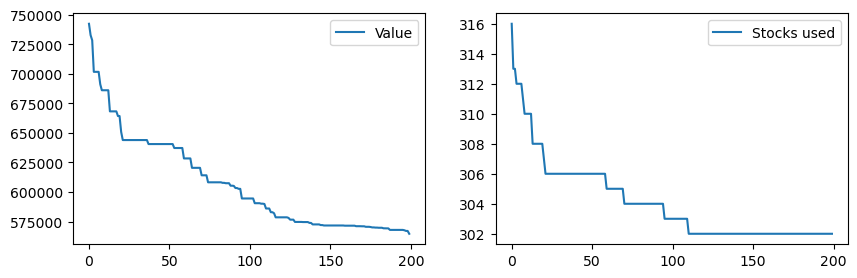

564699 302


In [64]:
orders = read_instance('test_instances/test_instance_11.csp')
solution, value, num_stocks = ga(orders,
                                 selection=rank_selection,
                                 crossover=generalized_order_crossover,
                                 mutation=mutation_shuffle,
                                 plot=True
                                )
print(value, num_stocks)

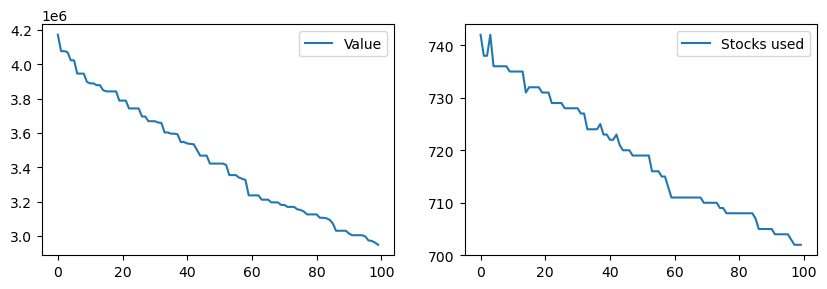

2948046 702


In [263]:
POPULATION_SIZE = 200
NUM_ITERS = 100
ELITISM_SIZE = 20
MUTATION_PROB = 0.02
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.5     # [1.0, 2.0]

orders = read_instance('test_instances/test_instance_20.csp')
solution, value, num_stocks = ga(orders,
                                 selection=roulette_selection,
                                 crossover=generalized_order_crossover,
                                 mutation=mutation_shuffle
                                )
print(value, num_stocks)

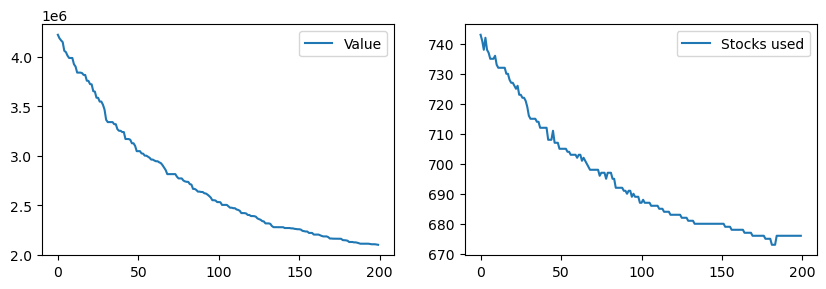

2098912 676


In [265]:
POPULATION_SIZE = 200
NUM_ITERS = 200
ELITISM_SIZE = 20
MUTATION_PROB = 0.02
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.5     # [1.0, 2.0]

orders = read_instance('test_instances/test_instance_20.csp')
solution, value, num_stocks = ga(orders,
                                 selection=rank_selection,
                                 crossover=generalized_order_crossover,
                                 mutation=mutation_inverse
                                )
print(value, num_stocks)

In [268]:
POPULATION_SIZE = 200
NUM_ITERS = 200
ELITISM_SIZE = 20
MUTATION_PROB = 0.02
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.5     # [1.0, 2.0]

orders = read_instance('test_instances/test_instance_20.csp')
solution, value, num_stocks = ga(orders,
                                 selection=tournament_selection,
                                 crossover=generalized_order_crossover,
                                 mutation=mutation_inverse
                                )
print(value, num_stocks)

2354288 684


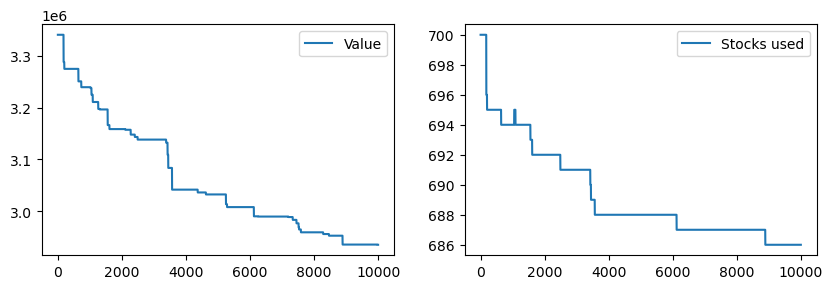

2935304 686


In [44]:
solution, value, num_stocks = simulated_annealing(solution, initial_temp, min_temp, a)
print(value, num_stocks)

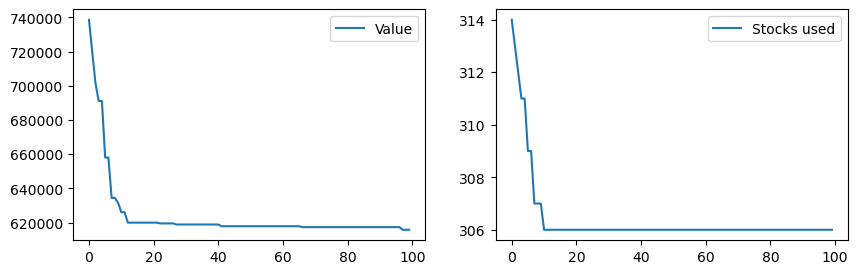

615782 306


In [275]:
POPULATION_SIZE = 50
NUM_ITERS = 100
ELITISM_SIZE = 8
MUTATION_PROB = 0.02
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.5     # [1.0, 2.0]

orders = read_instance('test_instances/test_instance_11.csp')
solution, value, num_stocks = ga(orders,
                                 selection=tournament_selection,
                                 crossover=generalized_order_crossover,
                                 mutation=mutation_swap,
                                 plot=True
                                )
print(value, num_stocks)

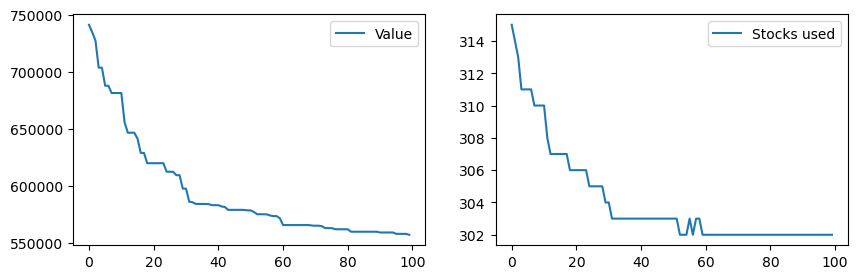

555838 302


In [290]:
POPULATION_SIZE = 80
NUM_ITERS = 100
ELITISM_SIZE = 10
MUTATION_PROB = 0.08
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.3     # [1.0, 2.0]

orders = read_instance('test_instances/test_instance_11.csp')
solution, value, num_stocks = ga(orders,
                                 selection=rank_selection,
                                 crossover=generalized_order_crossover,
                                 mutation=mutation_inverse,
                                 plot=True
                                )
print(value, num_stocks)

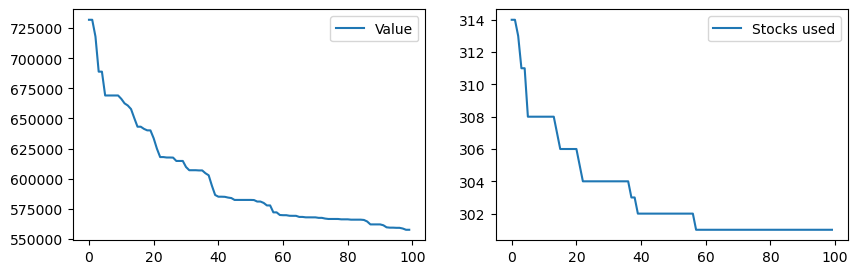

556962 301


In [292]:
POPULATION_SIZE = 80
NUM_ITERS = 100
ELITISM_SIZE = 10
MUTATION_PROB = 0.08
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.6     # [1.0, 2.0]

orders = read_instance('test_instances/test_instance_11.csp')
solution, value, num_stocks = ga(orders,
                                 selection=rank_selection,
                                 crossover=generalized_order_crossover,
                                 mutation=mutation_insert,
                                 plot=True
                                )
print(value, num_stocks)

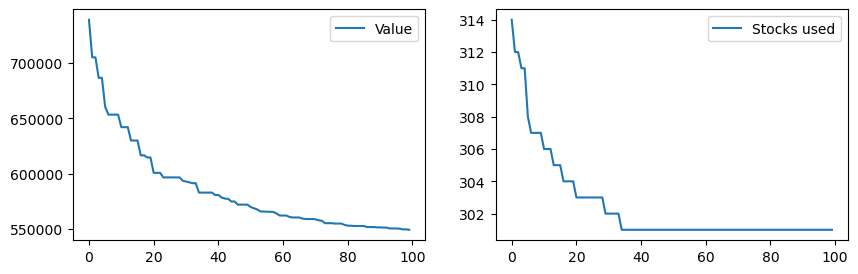

548868 301


In [70]:
POPULATION_SIZE = 80
NUM_ITERS = 100
ELITISM_SIZE = 10
MUTATION_PROB = 0.08
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.6     # [1.0, 2.0]

orders = read_instance('test_instances/test_instance_11.csp')
solution, value, num_stocks = ga(orders,
                                 selection=rank_selection,
                                 crossover=partially_mapped_crossover,
                                 mutation=mutation_insert,
                                 plot=True
                                )
print(value, num_stocks)

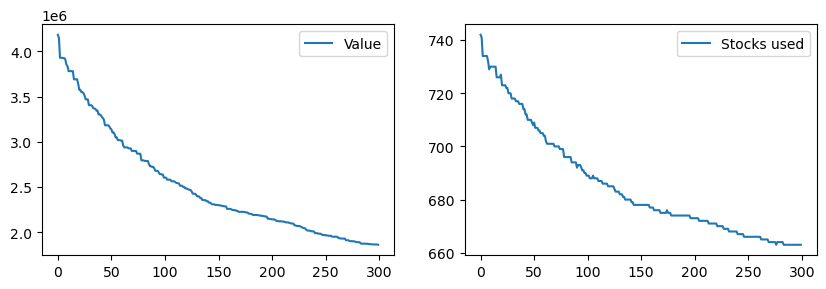

1860556 663


In [294]:
POPULATION_SIZE = 200
NUM_ITERS = 300
ELITISM_SIZE = 10
MUTATION_PROB = 0.08
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.6     # [1.0, 2.0]

orders = read_instance('test_instances/test_instance_20.csp')
solution, value, num_stocks = ga(orders,
                                 selection=rank_selection,
                                 crossover=generalized_order_crossover,
                                 mutation=mutation_insert,
                                 plot=True
                                )
print(value, num_stocks)

In [ ]:
POPULATION_SIZE = 400
NUM_ITERS = 200
ELITISM_SIZE = 24
MUTATION_PROB = 0.08
TOURNAMENT_SIZE = 6
SELECTION_PRESSURE = 1.6     # [1.0, 2.0]

orders = read_instance('test_instances/test_instance_20.csp')
solution, value, num_stocks = ga(orders,
                                 selection=tournament_selection,
                                 crossover=precedence_preservative_crossover,
                                 mutation=mutation_insert,
                                 plot=True
                                )
print(value, num_stocks)

In [ ]:
# the experiments showed the effectiveness of the proposed (DHM/ILC) when dealing with small population size, 
# while the proposed (ILM/DHC) was found to be more effective when using large population size

In [75]:
import random
from time import perf_counter
import pandas as pd

In [79]:
def test_all_instances(combination_num,
                       results_df,
                       POPULATION_SIZE,
                       ELITISM_SIZE,
                       MC_OPTION,
                       MUTATION_PROB,
                       CROSSOVER_PROB,
                       NUM_ITERS
                      ):
    
    for i in range(21):
        start = perf_counter()
        
        orders = read_instance(f'test_instances/test_instance_{i}.csp')
        
        solution, value, num_stocks = ga(orders,
                                         selection=tournament_selection,
                                         crossover=precedence_preservative_crossover,
                                         mutation=mutation_insert,
                                         plot=False,
                                         POPULATION_SIZE = POPULATION_SIZE,
                                         MC_OPTION = MC_OPTION,
                                         CROSSOVER_PROB = CROSSOVER_PROB,
                                         MUTATION_PROB = MUTATION_PROB,
                                         NUM_ITERS = NUM_ITERS,
                                         ELITISM_SIZE = ELITISM_SIZE
                                        )
        
        results_df.loc[combination_num, ['elitism size', 'mc option', 'mutation prob', 'crossover prob']] = [ELITISM_SIZE, MC_OPTION, MUTATION_PROB, CROSSOVER_PROB]
        results_df.loc[combination_num, f'instance {i} value, num stocks'] = (value, num_stocks)

In [81]:
TOURNAMENT_SIZE = 6

param_columns = ['elitism size', 'mc option', 'mutation prob', 'crossover prob']
instance_columns = [f'instance {i} value, num stocks' for i in range(21)]
columns = param_columns + instance_columns

results_df = pd.DataFrame(columns=columns)

mutation_lb = 0.05
mutation_ub = 0.2
crossover_lb = 0.7
crossover_ub = 0.95

num_combinations = 150

for i in range(num_combinations):
    print(f'Combination {i+1}/{num_combinations}')
    
#     POPULATION_SIZE = random.choice([50, 100, 300, 600, 800])
#     NUM_ITERS = random.choice([100, 200, 300, 400, 500])

    POPULATION_SIZE = 100
    NUM_ITERS = 100
    ELITISM_SIZE = int(random.choice([0, 0.02, 0.04, 0.06, 0.08, 0.1]) * POPULATION_SIZE)
    CROSSOVER_PROB = None
    MUTATION_PROB = None

    MC_OPTION = random.choice(['FIXED', 'DHM/ILC', 'ILM/DHC']) 
     
    if MC_OPTION == 'FIXED':
        CROSSOVER_PROB = random.choice([0.7, 0.75, 0.8, 0.85, 0.9])
        MUTATION_PROB = random.choice([0.05, 0.08, 0.1, 0.12,  0.15, 0.2])
            
    test_all_instances(i,
                       results_df,
                       POPULATION_SIZE,
                       ELITISM_SIZE,
                       MC_OPTION,
                       MUTATION_PROB,
                       CROSSOVER_PROB,
                       NUM_ITERS
                      )

Combination 1/150
Combination 2/150
Combination 3/150
Combination 4/150
Combination 5/150
Combination 6/150
Combination 7/150
Combination 8/150
Combination 9/150
Combination 10/150
Combination 11/150
Combination 12/150
Combination 13/150
Combination 14/150
Combination 15/150
Combination 16/150
Combination 17/150
Combination 18/150
Combination 19/150
Combination 20/150
Combination 21/150
Combination 22/150
Combination 23/150
Combination 24/150
Combination 25/150
Combination 26/150
Combination 27/150
Combination 28/150
Combination 29/150
Combination 30/150
Combination 31/150
Combination 32/150
Combination 33/150
Combination 34/150
Combination 35/150
Combination 36/150
Combination 37/150
Combination 38/150
Combination 39/150
Combination 40/150
Combination 41/150
Combination 42/150
Combination 43/150
Combination 44/150
Combination 45/150
Combination 46/150
Combination 47/150
Combination 48/150
Combination 49/150
Combination 50/150
Combination 51/150
Combination 52/150
Combination 53/150
Co

In [82]:
results_df

,elitism size,mc option,mutation prob,crossover prob,"instance 0 value, num stocks","instance 1 value, num stocks","instance 2 value, num stocks","instance 3 value, num stocks","instance 4 value, num stocks","instance 5 value, num stocks",...,"instance 11 value, num stocks","instance 12 value, num stocks","instance 13 value, num stocks","instance 14 value, num stocks","instance 15 value, num stocks","instance 16 value, num stocks","instance 17 value, num stocks","instance 18 value, num stocks","instance 19 value, num stocks","instance 20 value, num stocks"
0,0,ILM/DHC,None,None,"(620, 16)","(274, 19)","(7328, 49)","(5305, 51)","(1014, 33)","(103058, 127)",...,"(573937, 303)","(250943, 242)","(108933, 194)","(604481, 344)","(352721, 301)","(62126, 174)","(2478826, 605)","(1325641, 496)","(532945, 399)","(2758209, 694)"
1,0,DHM/ILC,None,None,"(720, 16)","(446, 19)","(6803, 49)","(4946, 50)","(1028, 33)","(103971, 127)",...,"(580553, 304)","(259815, 243)","(123140, 197)","(627547, 344)","(310741, 296)","(58636, 173)","(2465161, 607)","(1149246, 486)","(587142, 401)","(2894418, 703)"
2,6,DHM/ILC,None,None,"(1188, 17)","(487, 19)","(6929, 49)","(6914, 52)","(1059, 33)","(97889, 126)",...,"(572698, 303)","(238426, 240)","(104489, 195)","(543323, 339)","(363160, 301)","(59852, 174)","(2445065, 606)","(1297891, 492)","(623103, 403)","(2999531, 705)"
3,2,ILM/DHC,None,None,"(708, 16)","(365, 19)","(5942, 48)","(3575, 49)","(854, 33)","(97666, 126)",...,"(573835, 303)","(240111, 240)","(99665, 194)","(633168, 345)","(341014, 298)","(48196, 172)","(2404906, 604)","(1153731, 487)","(610520, 402)","(2758898, 697)"
4,6,DHM/ILC,None,None,"(1194, 17)","(326, 19)","(8025, 49)","(5172, 51)","(1187, 34)","(104663, 127)",...,"(591511, 304)","(220315, 238)","(96984, 193)","(606829, 345)","(390185, 305)","(54798, 171)","(2375681, 602)","(1426704, 499)","(576917, 400)","(2779017, 698)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,ILM/DHC,None,None,"(624, 16)","(670, 20)","(8523, 50)","(4636, 50)","(825, 33)","(104186, 127)",...,"(576095, 304)","(262574, 243)","(103545, 194)","(543811, 340)","(296879, 295)","(44994, 171)","(2442457, 605)","(1223126, 488)","(538928, 396)","(2729166, 694)"
146,6,ILM/DHC,None,None,"(1182, 17)","(724, 20)","(8567, 50)","(5251, 50)","(908, 33)","(103189, 127)",...,"(593241, 305)","(248708, 242)","(102928, 193)","(662028, 347)","(374781, 304)","(68516, 175)","(2464780, 606)","(1218374, 490)","(554277, 398)","(2740106, 693)"
147,0,ILM/DHC,None,None,"(651, 16)","(424, 19)","(5981, 48)","(4683, 50)","(852, 33)","(99259, 126)",...,"(578460, 303)","(233941, 241)","(96835, 193)","(589408, 342)","(333308, 301)","(54147, 172)","(2408292, 604)","(1239207, 489)","(533918, 398)","(2764563, 697)"
148,6,ILM/DHC,None,None,"(634, 16)","(325, 19)","(7393, 49)","(5725, 51)","(889, 33)","(98913, 126)",...,"(561595, 302)","(283479, 246)","(119287, 197)","(527835, 339)","(387111, 303)","(60882, 173)","(2392491, 602)","(1396921, 498)","(563828, 399)","(2941525, 701)"


In [83]:
results_df.to_csv('out.csv')

In [1]:
from time import perf_counter

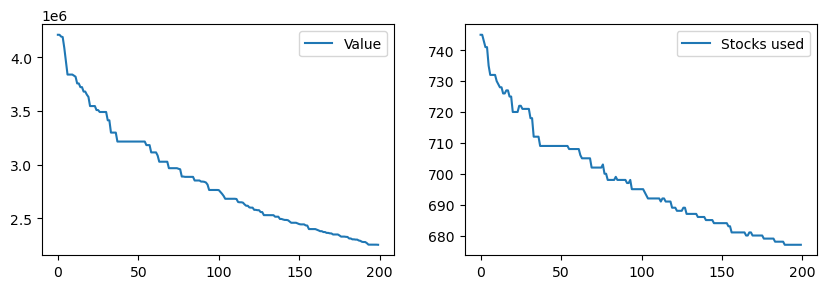

2249446 677
294.2159376640002


In [40]:
orders = read_instance('test_instances/test_instance_20.csp')
SELECTION_PRESSURE = 1.5     # [1.0, 2.0]


start = perf_counter()
solution, value, num_stocks = ga(orders,
                                 selection=rank_selection,
                                 crossover=partially_mapped_crossover,
                                 mutation=mutation_inverse,
                                 plot=True,
                                 POPULATION_SIZE = 200,
                                 MC_OPTION = 'FIXED',
                                 CROSSOVER_PROB = 1.0,
                                 MUTATION_PROB = 0.1,
                                 NUM_ITERS = 200,
                                 ELITISM_SIZE = 20
                                )
end = perf_counter()

print(value, num_stocks)
print(end - start)

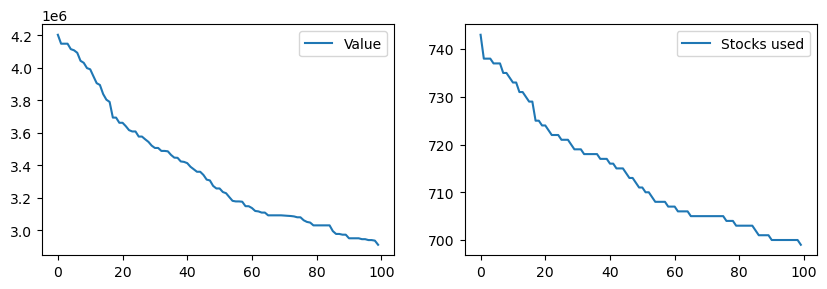

2906261 699
10.199676086000181


In [71]:
orders = read_instance('test_instances/test_instance_20.csp')
SELECTION_PRESSURE = 1.5     # [1.0, 2.0]


start = perf_counter()
solution, value, num_stocks = ga(orders,
                                 selection=tournament_selection,
                                 crossover=precedence_preservative_crossover,
                                 mutation=mutation_insert,
                                 plot=True,
                                 POPULATION_SIZE = 100,
                                 MC_OPTION = 'DHM/ILC',
                                 CROSSOVER_PROB = 1.0,
                                 MUTATION_PROB = 0.1,
                                 NUM_ITERS = 100,
                                 ELITISM_SIZE = 20
                                )
end = perf_counter()

print(value, num_stocks)
print(end - start)